## Figure 2 and 3: 

*Figure 2:*   
Occurrence of wind direction with height taken from the a) radiosondes, b) ICON-
LEM and c) ICON-NWP profiles (Aug. to Dec. 2020). The wind direction is binned in 10-degree
steps. The heights in ICON-NWP and the radiosondes are adapted to the ICON-LEM lev-
els. The radiosondes were started around 11 UTC and from the simulations, a single profile at
12 UTC was selected. The grey dashed lines indicate the level at 180 m

*Figure 3:*  
Frequency of occurrence of wind direction taken from the radiosondes (black dashed), ICON-LEM (red solid) and ICON-NWP (blue dashed-dotted) profiles (Aug. to Dec. 2020) for the single level at a height of ca. 180 m.

Package versions:   
* seaborn = 0.11.2
* matplotlib = 3.1.3
* pandas = 1.2.1
* numpy = 1.18.1
* xarray = 0.15.1

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.lines import Line2D 
import matplotlib.pyplot as plt

%matplotlib notebook

## 1. Data

### 1.1. Model 

In [2]:
path = "data/model/12UTC_icon_lem_meteograms/"
file = "nyalesund_icon_lem_12UTC_meteogram_202008-12.nc"
ds_icon_12UTC = xr.open_dataset(path+file)

path = "data/model/12UTC_icon_nwp_meteograms/"
file = "nyalesund_icon_nwp_12UTC_meteograms_202008-12.nc"
ds_icon_nwp_12UTC = xr.open_dataset(path+file)

In [3]:
# For 600m get 12 UTC
ds_icon_only12UTC = ds_icon_12UTC.where((ds_icon_12UTC.time.dt.minute == 0 ) & (ds_icon_12UTC.time.dt.second == 0), drop=True)
#hor wind components
u_meteogram = ds_icon_only12UTC.U.copy()
v_meteogram = ds_icon_only12UTC.V.copy()

# For 2km get 12 UTC
ds_icon_nwp_only12UTC = ds_icon_nwp_12UTC.where((ds_icon_nwp_12UTC.time.dt.minute == 0 ) & (ds_icon_nwp_12UTC.time.dt.second == 0), drop=True)
#hor wind components
u_nwp = ds_icon_nwp_only12UTC.U.copy()
v_nwp = ds_icon_nwp_only12UTC.V.copy()

In [4]:
# For heights in plots (In meters!)
height_index = 50 # Only plot until certain limit.
icon_height = ds_icon_12UTC.height_2[height_index:]

#### 1.2 For meteogram file compute wind direction

Given are $U$ and $V$ and I want the wind direction in 0-360°. I can use $\alpha = \arctan(\frac{v}{u})$ and cases:  
1. Quadrant (0 to 90°): -u,-v: 90 - $\alpha$ 
2. : -u,+v: $\alpha$ + 90
3. : +u,+v: 270 - $\alpha$ 
4. : +u,-v: $\alpha$ + 270 


In [5]:
# Compute wind direction in degree

alpha = np.rad2deg(np.arctan(v_meteogram/u_meteogram)) # in rad
abs_alpha = abs(alpha.values)
wind_dir_icon = abs_alpha.copy()

# For 2km
alpha_nwp = np.rad2deg(np.arctan(v_nwp/u_nwp)) # in rad
abs_alpha_nwp = abs(alpha_nwp.values)
wind_dir_nwp = abs_alpha_nwp.copy()

In [6]:
# LEM
u_neg_mask = u_meteogram < 0
u_pos_mask = u_meteogram >= 0

v_neg_mask = v_meteogram < 0
v_pos_mask = v_meteogram >= 0

# For NWP
u_neg_mask_nwp = u_nwp < 0
u_pos_mask_nwp = u_nwp >= 0

v_neg_mask_nwp = v_nwp < 0
v_pos_mask_nwp = v_nwp >= 0

In [7]:
# LEM
# Compute alpha depending on quadrant
alpha_0to90 = 90 - abs_alpha[u_neg_mask & v_neg_mask]
alpha_90to180 = abs_alpha[u_neg_mask & v_pos_mask] +90
alpha_180to270 = 270 - abs_alpha[u_pos_mask & v_pos_mask]
alpha_270to360 = abs_alpha[u_pos_mask & v_neg_mask] + 270

wind_dir_icon[ u_neg_mask & v_neg_mask ] = 90 - abs_alpha[u_neg_mask & v_neg_mask]
wind_dir_icon[ u_neg_mask & v_pos_mask ] = abs_alpha[u_neg_mask & v_pos_mask] +90
wind_dir_icon[ u_pos_mask & v_pos_mask ] = 270 - abs_alpha[u_pos_mask & v_pos_mask]
wind_dir_icon[ u_pos_mask & v_neg_mask ] = abs_alpha[u_pos_mask & v_neg_mask] + 270

In [8]:
# For NWP 
# Compute alpha depending on quadrant
alpha_0to90_nwp    = 90 - abs_alpha_nwp[u_neg_mask_nwp & v_neg_mask_nwp]
alpha_90to180_nwp  = abs_alpha_nwp[u_neg_mask_nwp & v_pos_mask_nwp] +90
alpha_180to270_nwp = 270 - abs_alpha_nwp[u_pos_mask_nwp & v_pos_mask_nwp]
alpha_270to360_nwp = abs_alpha_nwp[u_pos_mask_nwp & v_neg_mask_nwp] + 270

wind_dir_nwp[ u_neg_mask_nwp & v_neg_mask_nwp ] = 90 - abs_alpha_nwp[u_neg_mask_nwp & v_neg_mask_nwp]
wind_dir_nwp[ u_neg_mask_nwp & v_pos_mask_nwp ] = abs_alpha_nwp[u_neg_mask_nwp & v_pos_mask_nwp] +90
wind_dir_nwp[ u_pos_mask_nwp & v_pos_mask_nwp ] = 270 - abs_alpha_nwp[u_pos_mask_nwp & v_pos_mask_nwp]
wind_dir_nwp[ u_pos_mask_nwp & v_neg_mask_nwp ] = abs_alpha_nwp[u_pos_mask_nwp & v_neg_mask_nwp] + 270

### 1.3. Radiosonde
1. Read in data
2. Reformat data into an array with height and time sorted.

In [9]:
# Radiosonde data for 08.2020 to 12.2020
path = "/work/tkiszler/data/radiosondes/"
file = "nyalesund_RS_202008-12.nc"

RS_ds = xr.open_dataset(path+file)

In [10]:
# Formatting Radiosonde data because it is only given with the time coordinate.
# There aren't the same amount of timesteps for everyday ... doof wa
# For wind direction create array with [time,alt,wdir,icon-height]
wdir_alt_arr = np.empty([len(RS_ds.time.values),4])

In [11]:
max_height_RS = np.array([])
d = 1; m = 8; i = 0; h_i = 0

for m in range(8,13):
    max_day = int((RS_ds.time[RS_ds.time.dt.month == m].dt.day).max())
    
    for d in range(1,max_day+1):
        
        i_end = i + len(RS_ds.time[(RS_ds.time.dt.day == d) & (RS_ds.time.dt.month == m)].values)
        
        wdir_alt_arr[i:i_end,0] = RS_ds.time[(RS_ds.time.dt.day == d) & (RS_ds.time.dt.month == m)].values
        wdir_alt_arr[i:i_end,1] = RS_ds.alt[(RS_ds.time.dt.day == d) & (RS_ds.time.dt.month == m)].values
        wdir_alt_arr[i:i_end,2] = RS_ds.wdir[(RS_ds.time.dt.day == d) & (RS_ds.time.dt.month == m)].values
        
        try:
            max_height_RS = np.append(max_height_RS,[wdir_alt_arr[i:i_end,1].max()])
        except: 
            print("Skipped", d, m )
            continue
        
        i = i_end
        h_i+=1
        

Skipped 18 9
Skipped 20 9
Skipped 8 10
Skipped 11 10
Skipped 22 10


### 1.4 Reformating Data for 100 levels
Then I can compute the distributions for each level.   
For RS: wdir_alt_arr which includes height and wdir  
For 2km: wind_dir_nwp for wind direction and ds_icon_nwp_only12UTC.height_2 for height

In [12]:
# Adding the wind direction to the dataset  for 2km
ds_icon_nwp_only12UTC["WDIR"] = ds_icon_nwp_only12UTC.U.copy()
ds_icon_nwp_only12UTC.WDIR.values=wind_dir_nwp
# Add a dummy variable to later add icon 600m height to the 2km dataset
ds_icon_nwp_only12UTC["height_3"] = ds_icon_nwp_only12UTC.height_2.copy()

# Adding variable and then the wind direction to the dataset
ds_icon_only12UTC["WDIR"] = ds_icon_only12UTC.U.copy()
ds_icon_only12UTC.WDIR.values = wind_dir_icon


In [13]:
# Add actual height 
for h in range(0,len(ds_icon_only12UTC.height.values)-1):
    # use height so that we have lower and upper level and then height_2 for mid level
    h_i = ds_icon_only12UTC.height.values[h]
    h_iplus1 = ds_icon_only12UTC.height.values[h+1]

    wdir_alt_arr[(wdir_alt_arr[:,1] > h_iplus1) & (wdir_alt_arr[:,1] < h_i),3] = ds_icon_only12UTC.height_2.values[h]

    ds_icon_nwp_only12UTC.height_3.values[(ds_icon_nwp_only12UTC.height_3.values > h_iplus1 ) 
                                          & (ds_icon_nwp_only12UTC.height_3.values < h_i)] = ds_icon_only12UTC.height_2.values[h]


In [14]:
# Set missing values from 999 to nan
wdir_alt_arr[(wdir_alt_arr[:,2] > 360),2] = np.nan

### 1.5. Create 10 degree bins

In [15]:
## Meteograms 600m
wdir_occ_icon = np.empty([36, wind_dir_icon.shape[1]])  # 10 deg and 100 levels
wdir_freq_icon = np.empty([36, wind_dir_icon.shape[1]]) 

r_lim = np.arange(0,360,10)

for h in range(wind_dir_icon.shape[1]):
    for r in r_lim:
        r_i = int(r/10)
        wdir_occ_icon[r_i,h] = len(wind_dir_icon[(wind_dir_icon[:,h] > r) & (wind_dir_icon[:,h] <= r+10),h])
        
    wdir_freq_icon[:,h] = wdir_occ_icon[:,h]/sum(wdir_occ_icon[:,h])*100


In [16]:
## Meteograms 2km reformated to 100 levels
wdir_occ_nwp = np.empty([36, wind_dir_icon.shape[1]])  # 10 deg and 100 levels
wdir_freq_nwp = np.empty([36, wind_dir_icon.shape[1]]) 

r_lim = np.arange(0,360,10)

for h in range(wind_dir_icon.shape[1]-1):
    # select all levels in 600m range
    h_vals = ds_icon_nwp_only12UTC.height_2.where((ds_icon_nwp_only12UTC.height_2 < ds_icon_only12UTC.height_2[h]) 
                                     & (ds_icon_nwp_only12UTC.height_2 > ds_icon_only12UTC.height_2[h+1]),
                                     drop=True).values
    hi = np.asarray([np.where(ds_icon_nwp_only12UTC.height_2 == i) for i in h_vals]).flatten()
    
    for r in r_lim:
        r_i = int(r/10)
        wdir_occ_nwp[r_i,h] = np.count_nonzero((wind_dir_nwp[:,hi] > r) & (wind_dir_nwp[:,hi] <= r+10))
        
    wdir_freq_nwp[:,h] = wdir_occ_nwp[:,h]/sum(wdir_occ_nwp[:,h])*100

In [17]:
# Radiosonde with heights and degree bins
delta_h = 50
height_lim = np.arange(0,int(max_height_RS.max()),delta_h)
wdir_occ_RS_h_set = np.empty([36,len(height_lim)])
wdir_freq_RS_h_set = np.empty([36,len(height_lim)])

height_lim_icon = icon_height.values[::-1]
wdir_occ_RS_h_icon = np.empty([36,len(height_lim_icon)])
wdir_freq_RS_h_icon = np.empty([36,len(height_lim_icon)])

# with icon height:
for r in r_lim:
    r_i = int(r/10)
    wdir_sub = wdir_alt_arr[(wdir_alt_arr[:,2] > r) & (wdir_alt_arr[:,2] < r+10),:]
    for h in range(len(height_lim_icon)-1):
        wdir_occ_RS_h_icon[r_i,h] = len(wdir_sub[(wdir_sub[:,1] > height_lim_icon[h]) & (wdir_sub[:,1] <= height_lim_icon[h+1])])
        # Catch divide by zero error
        if wdir_occ_RS_h_icon[r_i,h] > 0: 
            wdir_freq_RS_h_icon[r_i,h] = wdir_occ_RS_h_icon[r_i,h]/len(wdir_alt_arr[(wdir_alt_arr[:,1] > height_lim_icon[h]) 
                                                                   & (wdir_alt_arr[:,1] <= height_lim_icon[h+1])])*100
        else:
            wdir_freq_RS_h_icon[r_i,h] = 0

Using the icon levels for the height bins leads to more counts in the higher level as more measurements are then summed up in one bin. There, only the percentage actually transports a message.

#### 1.6 For single layer plot (Figure 3)
Select boundary layer set and create pandas dataframe to create seaborn histplot.

In [18]:
# Select BL set
rs_bl = wdir_freq_RS_h_icon[:,83:]
lem_bl = wdir_freq_icon[:,83:] 
nwp_bl = wdir_freq_nwp[:,83:]

# Compute PDF of wdir for each height.
# Create panda data frame for containing the wind direction and the height. Missing data is nan.
df = pd.DataFrame(columns=['RS', 'ICON 600m', 'ICON 2km', 'height'])

# For radiosondes compute single level by setting limits accordingly 
hilim_up = 95
hilim_bottom = 96
df['RS'] = wdir_alt_arr[((wdir_alt_arr[:,3] < ds_icon_only12UTC.height.values[hilim_up]) & 
                         ( wdir_alt_arr[:,3] > ds_icon_only12UTC.height.values[hilim_bottom]) ),2]
df['height']  = np.round(wdir_alt_arr[((wdir_alt_arr[:,3] < ds_icon_only12UTC.height.values[hilim_up] ) &
                                      ( wdir_alt_arr[:,3] > ds_icon_only12UTC.height.values[hilim_bottom])),3])

# Add the wind direction from the lem and nwp runs to the radiosonde set.
# Start with values below 2km but above 40m (radiosonde data only available above 40m)
h_start=hilim_up  # ~2km: 75
h_end=hilim_bottom 

for h in range(h_start,h_end):
    # Select an add data from 600m runs
    # Create mask to select only specific height
    mask = np.asarray(df.height.values[:] == np.round(ds_icon_only12UTC.height_2.values[h]))
    # Create an array with the same length of the selected height and fill missing cases with nan.
    tmp_vals1 = np.append(ds_icon_only12UTC.WDIR.values[:,h], np.repeat(np.nan, len(df['ICON 600m'].values[mask]) -
                                                                        len(ds_icon_only12UTC.WDIR.values[:,h])))

    df['ICON 600m'].values[mask] =  tmp_vals1

    # Select the heights for the 2km runs
    tmp_vals2 = ds_icon_nwp_only12UTC.WDIR.values[:,ds_icon_nwp_only12UTC.height_3.values[:]==
                                                  ds_icon_only12UTC.height_2.values[h]]
    tmp_vals2 = tmp_vals2.reshape(tmp_vals2.shape[0]*tmp_vals2.shape[1])
    tmp_vals2 = np.append(tmp_vals2, np.repeat(np.nan, len(df['ICON 2km'].values[mask])-len(tmp_vals2)))
    df['ICON 2km'].values[mask] = tmp_vals2

    
df['ICON 600m'] = df['ICON 600m'].astype(float)
df['ICON 2km'] = df['ICON 2km'].astype(float)

## 2. Plots
### 2.1 Plot Frequency with Height

<IPython.core.display.Javascript object>


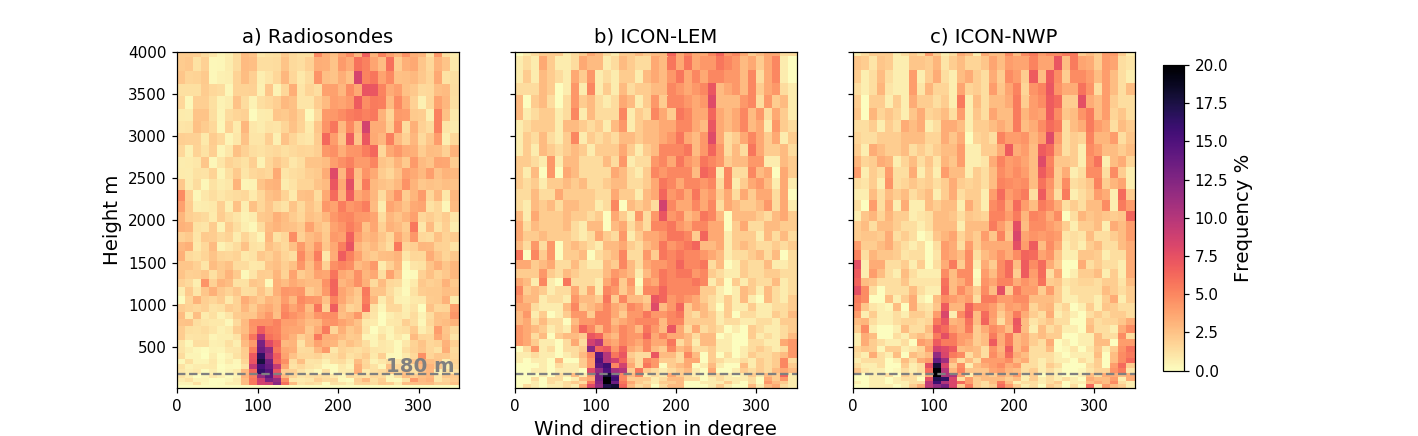

In [21]:
# Frequency

fsize=13

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(13,4))
mp = ax1.pcolormesh(r_lim, height_lim_icon, wdir_freq_RS_h_icon.transpose(), cmap="magma_r", 
                   vmin=0, vmax=20, shading="auto")
ax1.set_ylabel("Height m", fontdict={ "fontsize":fsize})
ax1.set_ylim(10,4000)
ax1.plot((0,350), (180,180), linestyle="dashed", color="grey")
ax1.set_title("a) Radiosondes", fontdict={ "fontsize":fsize})

# LEM
mp = ax2.pcolormesh(r_lim, icon_height, wdir_freq_icon[:,height_index:].transpose(),cmap="magma_r",
                  vmin=0, vmax=20, shading="auto")
ax2.set_xlabel("Wind direction in degree", fontdict={"fontsize":fsize} )
ax2.set_ylim(10,4000)
ax2.yaxis.set_ticklabels([])
ax2.plot((0,350), (180,180), linestyle="dashed", color="grey")
ax2.set_title("b) ICON-LEM", fontdict={ "fontsize":fsize})

# For 2km
# For heights in plots (In meters!)
mp = ax3.pcolormesh(r_lim, ds_icon_12UTC.height_2[50:],
                   wdir_freq_nwp[:,50:].transpose(),
                   cmap="magma_r",
                   vmin=0, vmax=20, shading="auto")
ax3.set_ylim(10,4000)
ax3.yaxis.set_ticklabels([])
ax3.plot((0,350), (180,180), linestyle="dashed", color="grey")
ax3.set_title("c) ICON-NWP", fontdict={ "fontsize":fsize})

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.15, 0.015, 0.7])
cb = fig.colorbar(mp, cax=cbar_ax) #, label="Frequency %", fontdict={ "fontsize":14})
cb.set_label("Frequency %", fontdict={ "fontsize":fsize})

font = {'family': 'sans',         #'cursive',
        'color':  'grey',
        'weight': 'bold',
        'size': fsize,
        }

ax1.text(260, 200, "180 m",fontdict = font )
plt.savefig("figure_2_wind_direction_revised.png", bbox_inches="tight", dpi=300, format="png")

Figure 2: Occurence of horizontal wind direction with height


### 2.2. Plot single layer distribution

<IPython.core.display.Javascript object>


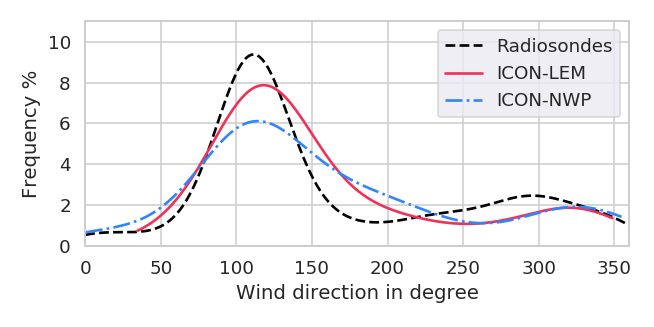

In [29]:
### Single level histogram
sns.set_style("whitegrid")

fig, ax1 = plt.subplots(figsize=(6,3))

stat_type='percent'
binwidth_n = 10

sns.set(font_scale=1.1)

sns.histplot(np.asarray(df["RS"]), kde = True, binwidth=binwidth_n, binrange=[0,360],
             color="black", label="Radiosondes", linewidth=0,
             kde_kws={'bw_adjust':1, 'clip':(0,360)}, line_kws={'linestyle':'dashed', 'lw':1.75},
             alpha=0.0, stat=stat_type, ax= ax1)
sns.histplot(np.asarray(df["ICON 600m"]), binwidth = binwidth_n, binrange=[0,360],
                   kde=True, color="#EE3359", label="ICON-LEM", linewidth=0,
                   kde_kws={'bw_adjust':1, 'clip':(0,360)},  line_kws={'lw':1.75},
                   alpha=0.0, stat=stat_type, ax = ax1)
sns.histplot(np.asarray(df["ICON 2km"]), kde=True, color="#3185FC", label="ICON-NWP",
             binwidth=binwidth_n, binrange=[0,360], linewidth=0,
             kde_kws={'bw_adjust':1, 'clip':(0,360)}, line_kws={'linestyle':'-.', 'lw':1.75},
             alpha=0.0, stat=stat_type, ax = ax1)

ax1.set_xlim(0,360)
ax1.set_ylim(0,11)
ax1.set_xlabel("Wind direction in degree", fontsize=13)
ax1.set_ylabel("Frequency %", fontsize=13)
#plt.legend(fontsize=13)

plt.tight_layout()

legend_elements = [
                   Line2D([0], [0], color='black', label='Radiosondes',lw = 1.75, linestyle="dashed"),
                   Line2D([0], [0], color='#EE3359', lw=1.75, label='ICON-LEM'),
                   Line2D([0], [0], label='ICON-NWP', color='#3185FC', lw = 1.75, linestyle="-.")
                  ]

plt.legend(handles=legend_elements)
plt.savefig("figure_3_wind_direction_single_layer_revised.png", bbox_layout="tight", dpi=300, format="png")